In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
from torchvision.transforms import v2
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from typing import cast, Tuple

In [2]:
import spoofdet.config as config
from spoofdet.efficient_net.model_utils import check_dataset_distribution, display_train_result, analyze_spoof_types, analyze_dataset_spoof_distribution, display_params, verify_subject_split, get_data_for_training, get_model, invert_label
from spoofdet.train import train_model
from spoofdet.evaluate import evaluate_model
from spoofdet.data_processing import get_transform_pipeline, create_subset
from spoofdet.utils import check_image, check_augmented_image, save_results
from spoofdet.dataset import CelebASpoofDataset

## params

In [3]:
EPOCHS = 20
EARLY_STOPPING_PATIENCE = 5
TARGET_SIZE = 384
NUM_WORKERS = 2
BATCH_SIZE = config.BATCH_SIZE

In [4]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gpu_transforms_train, gpu_transforms_val = get_transform_pipeline(device=device, target_size=TARGET_SIZE)

In [6]:
cpu_transform = transforms.Compose([
    # Resize removed - GPU transforms will handle it
    transforms.ToTensor(),  # Only converts PIL Image to tensor [0, 1]
])

train_data = datasets.ImageFolder(
    root=config.REAL_VS_FAKE_PATH / 'train',
    transform=cpu_transform,
    target_transform=invert_label
)

val_data = datasets.ImageFolder(
    root=config.REAL_VS_FAKE_PATH / 'valid',
    transform=cpu_transform,
    target_transform=invert_label
)

test_data = datasets.ImageFolder(
    root=config.REAL_VS_FAKE_PATH / 'test',
    transform=cpu_transform,
    target_transform=invert_label
)

In [7]:
train_idx = torch.randperm(len(train_data))[:5000].tolist()
val_idx = torch.randperm(len(val_data))[:2000].tolist()
test_idx = torch.randperm(len(test_data))[:2000].tolist()
train_sub_data = Subset(train_data, train_idx)
val_sub_data = Subset(val_data, val_idx)
test_sub_data = Subset(test_data, test_idx)

In [8]:
train_loader = DataLoader(train_sub_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True, 
                          num_workers=NUM_WORKERS, 
                          pin_memory=True,
                          persistent_workers=True,
                          drop_last=True)
val_loader = DataLoader(val_sub_data, 
                        batch_size=BATCH_SIZE, 
                        shuffle=False, 
                        num_workers=NUM_WORKERS, 
                        pin_memory=True,
                        persistent_workers=True,
                        drop_last=True)
test_loader = DataLoader(test_sub_data, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False, 
                         num_workers=NUM_WORKERS, 
                         pin_memory=True,
                         persistent_workers=True,
                         drop_last=True)

In [9]:
img, label = train_data[0] 

print(f"Label after transform: {label}")

Label after transform: 1


In [10]:
model_path = "train_results/train_15/model.pt"


In [11]:
model = models.efficientnet_v2_s(weights=None)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(cast(int, in_features), 2)
model.load_state_dict(torch.load(model_path))
model = model.to(device)

In [ ]:
# Verify the checkpoint loaded correctly
checkpoint = torch.load(model_path)
print(f"Checkpoint keys: {list(checkpoint.keys())[:5]}...")  # Show first 5 keys
print(f"Classifier weight shape in checkpoint: {checkpoint['classifier.1.weight'].shape}")
print(f"Classifier bias shape in checkpoint: {checkpoint['classifier.1.bias'].shape}")

# Check a sample weight value before loading
print(f"\nBefore loading - sample classifier weight: {model.classifier[1].weight[0, 0].item()}")

In [ ]:
# Now actually load the model and verify
model.load_state_dict(checkpoint)
model = model.to(device)

# Check the same weight after loading - should be different!
print(f"\nAfter loading - sample classifier weight: {model.classifier[1].weight[0, 0].item()}")
print(f"Sample feature weight: {list(model.features[0][0].weight.flatten()[:3])}")

# Check if weights actually changed
print("\n✓ Weights loaded successfully!" if model.classifier[1].weight[0, 0].item() != 0 else "⚠ Warning: weights might not be loaded")

In [ ]:
# Quick sanity check - run a forward pass before training
model.eval()
with torch.no_grad():
    sample_batch = next(iter(val_loader))
    images, labels = sample_batch
    images = images.to(device)
    images = gpu_transforms_val(images)
    outputs = model(images)
    loss = criterion(outputs, labels.to(device))
    print(f"\nPre-training validation loss on one batch: {loss.item():.4f}")
    print(f"Sample output logits: {outputs[0].cpu()}")
    print(f"Sample softmax probs: {torch.softmax(outputs[0], dim=0).cpu()}")
model.train()

In [12]:
print("Type:", type(model.classifier))
print("Value:", model.classifier)

Type: <class 'torch.nn.modules.container.Sequential'>
Value: Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)


In [13]:

assert isinstance(model.classifier, nn.Module), "Error: model.classifier is not a Module!"
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

In [ ]:

assert isinstance(model.classifier, nn.Module), "Error: model.classifier is not a Module!"
optimizer = torch.optim.AdamW(params=model.classifier.parameters(), lr=1e-4, weight_decay=1e-5)

print(f'Using device: {device}')

Using device: cuda


In [15]:
model, history = train_model(
    model=model,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=EPOCHS,
    profiler_log_name='fine_tune_efficient_net_profiler',
    train_transforms=gpu_transforms_train,
    val_transforms=gpu_transforms_val,
    early_stopping_limit=EARLY_STOPPING_PATIENCE
)

Epoch [1/20] |Time: 0m 45s Train Loss: 1.3325 |Val Loss: 1.2740 | Val Precision: 39.82% | Val Accuracy: 43.60% | Val Recall: 27.29% | Val F1: 32.39%
  -> New best model saved!
Epoch [2/20] |Time: 0m 26s Train Loss: 1.1382 |Val Loss: 1.1115 | Val Precision: 43.36% | Val Accuracy: 47.08% | Val Recall: 22.61% | Val F1: 29.72%
  -> New best model saved!
Epoch [3/20] |Time: 0m 25s Train Loss: 0.9623 |Val Loss: 0.8738 | Val Precision: 54.46% | Val Accuracy: 53.68% | Val Recall: 39.21% | Val F1: 45.59%
  -> New best model saved!
Epoch [4/20] |Time: 0m 25s Train Loss: 0.8281 |Val Loss: 0.7299 | Val Precision: 60.81% | Val Accuracy: 61.24% | Val Recall: 61.00% | Val F1: 60.90%
  -> New best model saved!
Epoch [5/20] |Time: 0m 25s Train Loss: 0.7402 |Val Loss: 0.6505 | Val Precision: 65.18% | Val Accuracy: 66.58% | Val Recall: 69.76% | Val F1: 67.39%
  -> New best model saved!
Epoch [6/20] |Time: 0m 25s Train Loss: 0.6652 |Val Loss: 0.5976 | Val Precision: 68.71% | Val Accuracy: 70.82% | Val Rec

D:\JoshFile\Github\spoofing-recognition\src\spoofdet\efficient_net\model_utils.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_loss.show()
D:\JoshFile\Github\spoofing-recognition\src\spoofdet\efficient_net\model_utils.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_precision.show()


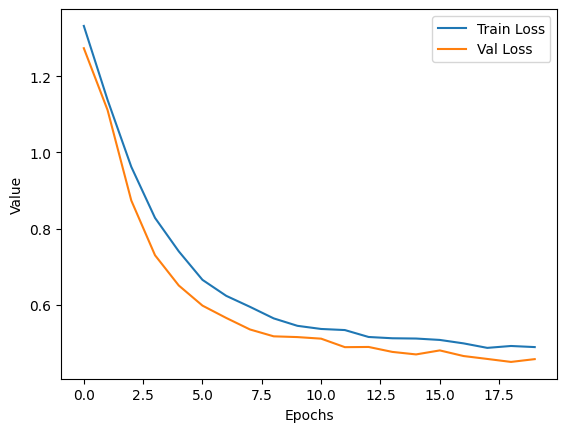

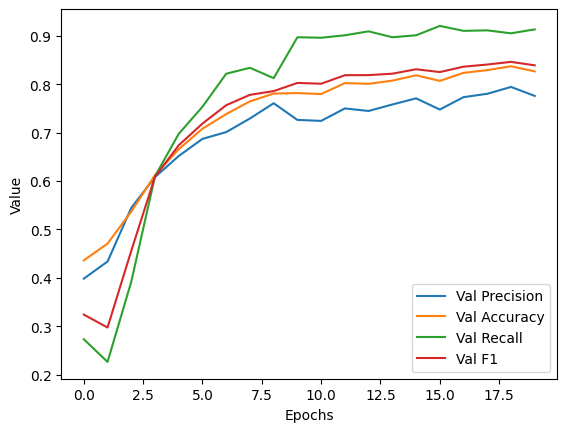

In [16]:
train_loss_fig, precision_fig = display_train_result(history)


Confusion Matrix:
         Predicted Live | Predicted Spoof
Live           751     |        268
Spoof          108     |        857


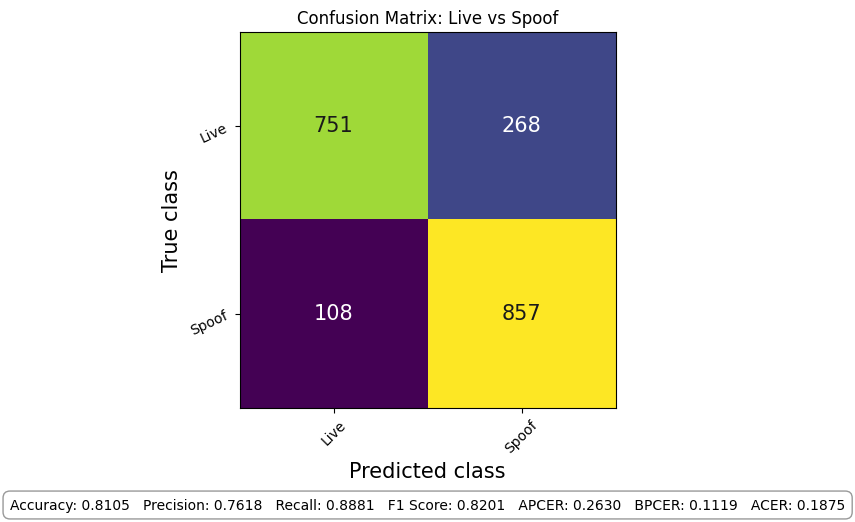

Accuracy: 0.8105
Precision: 0.7618
Recall:    0.8881
F1 Score:  0.8201
Spoofing Metrics: APCER: 0.2630, BPCER: 0.1119, ACER: 0.1875


In [17]:
confusion_matrix, accuracy, precision, recall, f1, spoof_metric_val  = evaluate_model(model=model, dataloader=test_loader, device=device, val_transforms=gpu_transforms_val)


Confusion Matrix:
         Predicted Live | Predicted Spoof
Live           893     |        126
Spoof          221     |        744


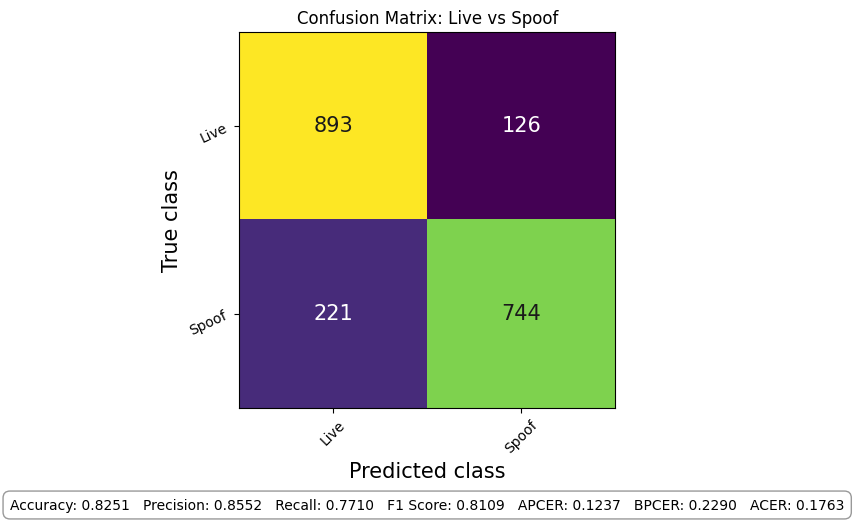

Accuracy: 0.8251
Precision: 0.8552
Recall:    0.7710
F1 Score:  0.8109
Spoofing Metrics: APCER: 0.1237, BPCER: 0.2290, ACER: 0.1763


In [18]:
confusion_matrix, accuracy, precision, recall, f1, spoof_metric_val  = evaluate_model(model=model, dataloader=test_loader, device=device, val_transforms=gpu_transforms_val, threshold=0.582, final_activation="sigmoid")


Confusion Matrix:
         Predicted Live | Predicted Spoof
Live           820     |        199
Spoof          149     |        816


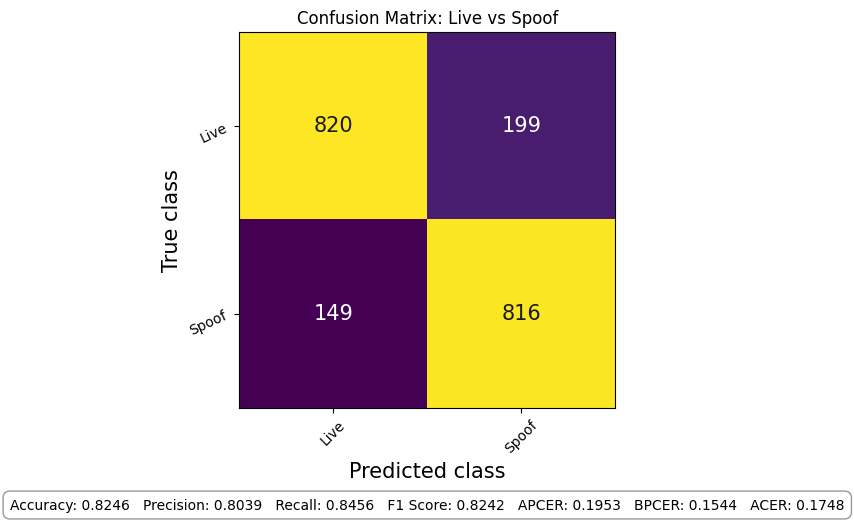

Accuracy: 0.8246
Precision: 0.8039
Recall:    0.8456
F1 Score:  0.8242
Spoofing Metrics: APCER: 0.1953, BPCER: 0.1544, ACER: 0.1748


In [19]:
confusion_matrix, accuracy, precision, recall, f1, spoof_metric_val  = evaluate_model(model=model, dataloader=test_loader, device=device, val_transforms=gpu_transforms_val, threshold=0.582, final_activation="softmax")

In [20]:
save_results(
    model=model,
    confusion_matrix_fig=confusion_matrix,
    train_loss_fig=train_loss_fig,
    precision_fig=precision_fig,
    params={
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "early_stopping_patience": EARLY_STOPPING_PATIENCE,
        "target_size": TARGET_SIZE,
        "optimizer": "AdamW",
        "learning_rate": 1e-4,
        "weight_decay": 1e-5,
        "criterion": "CrossEntropyLoss with label smoothing 0.1"
    },
    spoof_fig=None,
    save_path="fine_tune_results"
)

Saving results to: fine_tune_results\train_0


AttributeError: 'NoneType' object has no attribute 'savefig'